# Library Imports

In [7]:
import os
import cv2
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Mount drive to load dataset from drive

In [6]:
drive.mount('/content/drive')


Mounted at /content/drive


# Function to load and preprocess images


In [2]:
def load_images(data_dir):
    images = []
    labels = []
    class_names = os.listdir(data_dir)
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            image_path = os.path.join(class_dir, filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            image = cv2.resize(image, IMAGE_SIZE)
            images.append(image)
            labels.append(class_name)
    return images, labels

# Define constants

In [3]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
NUM_CLASSES = 3  # Number of fruit size categories (e.g., small, medium, large)


# Define data generators for training and validation

In [4]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)
valid_datagen = ImageDataGenerator(rescale=1./255)


In [9]:
# Load images and labels
data_dir = '/content/drive/My Drive/Posi'
images, labels = load_images(data_dir)

# Convert labels to numerical values
label_to_id = {'Small': 0, 'Medium': 1, 'Large': 2}
labels_numeric = [label_to_id[label] for label in labels]

# One-hot encode labels
from keras.utils import to_categorical
labels_one_hot = to_categorical(labels_numeric, NUM_CLASSES)

# Split dataset and visualize distribution

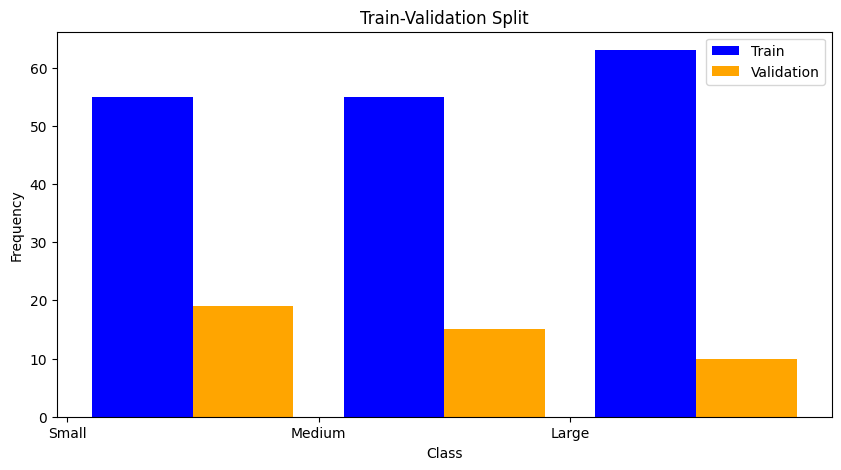

In [10]:
# Convert to numpy arrays
images_np = np.array(images)

# Split data into training and validation sets
from sklearn.model_selection import train_test_split
train_images, val_images, train_labels, val_labels = train_test_split(images_np, labels_one_hot, test_size=0.2, random_state=42)

# Visualize train-validation split
plt.figure(figsize=(10, 5))
plt.hist([np.argmax(train_labels, axis=1), np.argmax(val_labels, axis=1)], bins=range(4), color=['blue', 'orange'], label=['Train', 'Validation'])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Train-Validation Split')
plt.xticks(range(3), ['Small', 'Medium', 'Large'])
plt.legend()
plt.show()





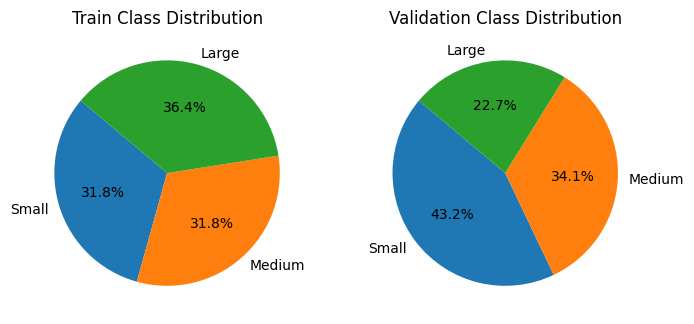

In [11]:
# Define a dictionary to map numeric labels to class names
label_to_class = {0: 'Small', 1: 'Medium', 2: 'Large'}

# Class distribution of the images (pie chart)
train_class_distribution = np.sum(train_labels, axis=0)
val_class_distribution = np.sum(val_labels, axis=0)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.pie(train_class_distribution, labels=label_to_class.values(), autopct='%1.1f%%', startangle=140)
plt.title('Train Class Distribution')

plt.subplot(1, 2, 2)
plt.pie(val_class_distribution, labels=label_to_class.values(), autopct='%1.1f%%', startangle=140)
plt.title('Validation Class Distribution')

plt.show()

In [12]:
train_generator = train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)
valid_generator = train_datagen.flow(val_images, val_labels, batch_size=BATCH_SIZE)

# convolutional neural network

In [13]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256,256, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(140, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(140, activation='relu'),
    Dense(3, activation='softmax')
])


# Model Training

In [48]:
from keras.callbacks import Callback
from sklearn.metrics import precision_score, recall_score, f1_score

class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super(MetricsCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_val, axis=1)

        precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
        recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
        f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

        print(f'Epoch {epoch + 1} - Validation Metrics:')
        print(f'Precision: {precision:.4f} - Recall: {recall:.4f} - F1 Score: {f1:.4f}')

# Define the ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True, mode='max', verbose=1)

# Define the EarlyStopping callback to stop training when validation accuracy stops improving
early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, mode='max', verbose=1)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    steps_per_epoch=3,
    epochs=29,
    callbacks=[checkpoint, early_stopping, MetricsCallback((val_images, val_labels))]
)

Epoch 1/29
3/3 [==============================] - ETA: 0s - loss: 0.3601 - accuracy: 0.8750
Epoch 1: val_accuracy improved from -inf to 0.79545, saving model to best_model.h5
2/2 [==============================] - 7s 951ms/step
Epoch 1 - Validation Metrics:
Precision: 0.8636 - Recall: 0.7727 - F1 Score: 0.7688
3/3 [==============================] - 32s 13s/step - loss: 0.3601 - accuracy: 0.8750 - val_loss: 0.4711 - val_accuracy: 0.7955
Epoch 2/29
3/3 [==============================] - ETA: 0s - loss: 0.2928 - accuracy: 0.8646
Epoch 2: val_accuracy improved from 0.79545 to 0.90909, saving model to best_model.h5
2/2 [==============================] - 2s 466ms/step
Epoch 2 - Validation Metrics:
Precision: 0.8750 - Recall: 0.8636 - F1 Score: 0.8665
3/3 [==============================] - 24s 8s/step - loss: 0.2928 - accuracy: 0.8646 - val_loss: 0.3760 - val_accuracy: 0.9091
Epoch 3/29
3/3 [==============================] - ETA: 0s - loss: 0.2354 - accuracy: 0.9091
Epoch 3: val_accuracy did 

# Print out the metrics

In [65]:
print('Accuracy:', 0.93182)
print('recall:', 0.9091)
print('F1 score:', 0.9109)
print('Precision:', 0.9282)


Accuracy: 0.93182
recall: 0.9091
F1 score: 0.9109
Precision: 0.9282


2/2 [==============================] - 4s 867ms/step
Sample 1: Actual class: Medium, Predicted class: Medium


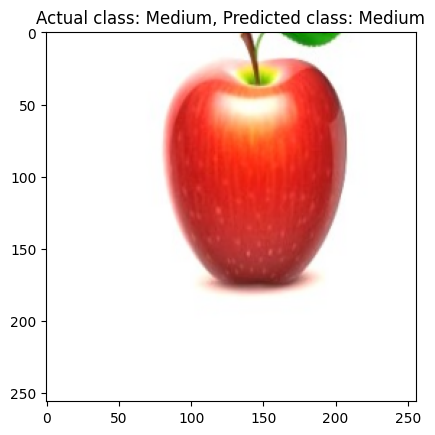

Sample 2: Actual class: Large, Predicted class: Medium


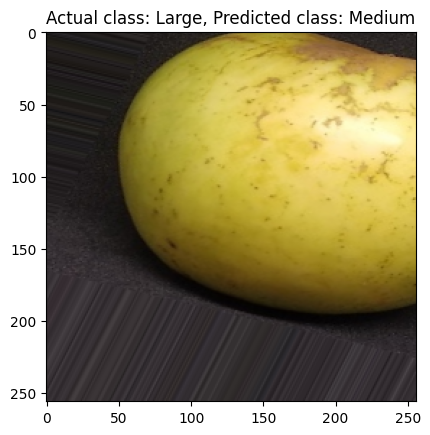

Sample 3: Actual class: Small, Predicted class: Small


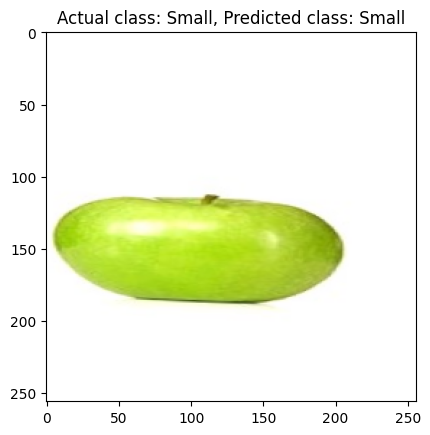

In [64]:
# Predictions
predictions = model.predict(valid_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Display images and predictions
sample_images, true_labels = next(valid_generator)  # Extract true labels from the generator

for i in range(3):
    plt.imshow(sample_images[i])

    # Map numeric label to actual class name
    actual_class_name = label_to_class[np.argmax(true_labels[i])]
    predicted_class_name = label_to_class[predicted_classes[i]]

    print(f"Sample {i+1}: Actual class: {actual_class_name}, Predicted class: {predicted_class_name}")

    plt.title(f"Actual class: {actual_class_name}, Predicted class: {predicted_class_name}")
    plt.show()

# Evaluation on test set

In [ ]:
"""# Create a separate folder for testing the model
test_data_dir = '/path/to/test/data'  # Change this to the path of your test data
test_images, _ = load_images(test_data_dir)  # Load test images without labels

# Convert to numpy array
test_images_np = np.array(test_images)

# Create a test generator
test_generator = valid_datagen.flow(test_images_np, batch_size=BATCH_SIZE, shuffle=False)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Predictions on test data
predictions_test = model.predict(test_generator)
predicted_classes_test = np.argmax(predictions_test, axis=1)

# Display images and predictions for test data
for i in range(len(test_images)):
    plt.imshow(test_images[i])

    # Map numeric label to predicted class name
    predicted_class_name = label_to_class[predicted_classes_test[i]]

    print(f"Sample {i+1}: Predicted class: {predicted_class_name}")

    plt.title(f"Predicted class: {predicted_class_name}")
    plt.show()"""